In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
from sklearn.impute import SimpleImputer
import scipy.stats as st
import scipy.stats.mstats as mst
from sklearn.cluster import KMeans

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas_profiling

from matplotlib import rcParams
import warnings

warnings.filterwarnings("ignore")

# tamaño de la figura en pulgadas
rcParams["figure.figsize"] = 10, 6
np.random.seed(42)

In [3]:
clientes = pd.read_csv(r'C:/airflow/docker-airflow-master/limpia/olist_customers_dataset.csv',sep=";")
productos = pd.read_csv(r'C:/airflow/docker-airflow-master/limpia/olist_products_dataset.csv',sep=";")
pagos = pd.read_csv(r'C:/airflow/docker-airflow-master/limpia/olist_order_payments_dataset.csv',sep=";")
geoloc = pd.read_csv(r'C:/airflow/docker-airflow-master/limpia/olist_geolocation_dataset.csv',sep=";", on_bad_lines='skip')
reviews = pd.read_csv(r'C:/airflow/docker-airflow-master/limpia/olist_order_reviews_dataset.csv',sep=";", on_bad_lines='skip')
venta = pd.read_csv(r'C:/airflow/docker-airflow-master/limpia/olist_orders_dataset.csv',sep=";") 
vendedores = pd.read_csv(r'C:/airflow/docker-airflow-master/limpia/olist_sellers_dataset.csv',sep=";")
items = pd.read_csv(r'C:/airflow/docker-airflow-master/limpia/olist_order_items_dataset.csv',sep=";")
Categoria = pd.read_csv(r'C:/airflow/docker-airflow-master/limpia/product_category_name_translation.csv',sep=";")
TratoCerrado = pd.read_csv(r'C:/airflow/docker-airflow-master/limpia/olist_closed_deals_dataset.csv',sep=";", on_bad_lines='skip')
ClientePotencial = pd.read_csv(r'C:/airflow/docker-airflow-master/limpia/olist_marketing_qualified_leads_dataset.csv',sep=";")

In [4]:
clientes["customer_id"]=clientes["customer_id"].astype(str)
clientes["customer_unique_id"]=clientes["customer_unique_id"].astype(str)


In [5]:
clientes.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
dtype: int64

In [6]:
clientes["customer_id"].unique().shape

(96381,)

In [7]:
clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96381 entries, 0 to 96380
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               96381 non-null  object
 1   customer_unique_id        96381 non-null  object
 2   customer_zip_code_prefix  96381 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


In [9]:
venta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [7]:
venta["order_purchase_timestamp"]=pd.to_datetime(venta["order_purchase_timestamp"])
venta["order_approved_at"]=pd.to_datetime(venta["order_approved_at"])
venta["order_delivered_carrier_date"]=pd.to_datetime(venta["order_delivered_carrier_date"])
venta["order_delivered_customer_date"]=pd.to_datetime(venta["order_delivered_customer_date"])
venta["order_estimated_delivery_date"]=pd.to_datetime(venta["order_estimated_delivery_date"])



In [8]:
venta["customer_id"].unique().shape

(99441,)

In [9]:
venta["order_id"].unique().shape

(99441,)

In [10]:
venta.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [11]:
venta.sort_values( by= "order_purchase_timestamp")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
4541,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,NaT,2016-10-20
4396,e5fa5a7210941f7d56d0208e4e071d35,683c54fc24d40ee9f8a6fc179fd9856c,canceled,2016-09-05 00:15:34,2016-10-07 13:17:15,NaT,NaT,2016-10-28
10071,809a282bbd5dbcabb6f2f724fca862ec,622e13439d6b5a0b486c435618b2679e,canceled,2016-09-13 15:24:19,2016-10-07 13:16:46,NaT,NaT,2016-09-30
30710,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04
83078,71303d7e93b399f5bcd537d124c0bcfa,b106b360fe2ef8849fbbd056f777b4d5,canceled,2016-10-02 22:07:52,2016-10-06 15:50:56,NaT,NaT,2016-10-25
...,...,...,...,...,...,...,...,...
50387,392ed9afd714e3c74767d0c4d3e3f477,2823ffda607a2316375088e0d00005ec,canceled,2018-09-29 09:13:03,NaT,NaT,NaT,2018-10-15
88500,616fa7d4871b87832197b2a137a115d2,bf6181a85bbb4115736c0a8db1a53be3,canceled,2018-10-01 15:30:09,NaT,NaT,NaT,2018-10-23
31891,a2ac6dad85cf8af5b0afb510a240fe8c,4c2ec60c29d10c34bd49cb88aa85cfc4,canceled,2018-10-03 18:55:29,NaT,NaT,NaT,2018-10-16
68373,b059ee4de278302d550a3035c4cdb740,856336203359aa6a61bf3826f7d84c49,canceled,2018-10-16 20:16:02,NaT,NaT,NaT,2018-11-12


In [12]:
value = np.nan
def impute_date_rowise(x):
    global value
    if pd.isnull(value):
        value = x
        return value
    elif not pd.isnull(x):
        value = x
        return x
    else:
        value = (value + pd.DateOffset(days=1)).date()
        return value

venta["order_delivered_carrier_date"].apply(impute_date_rowise)
venta.head(10)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07
8,76c6e866289321a7c93b82b54852dc33,f54a9f0e6b351c431402b8461ea51999,delivered,2017-01-23 18:29:09,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-02-02 14:08:10,2017-03-06
9,e69bfb5eb88e0ed6a785585b27e16dbf,31ad1d1b63eb9962463f764d4e6e0c9d,delivered,2017-07-29 11:55:02,2017-07-29 12:05:32,2017-08-10 19:45:24,2017-08-16 17:14:30,2017-08-23


In [13]:
ventaNulos=venta[venta.isnull().any(1)]
ventaNulos.head(15)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07
162,36530871a5e80138db53bcfd8a104d90,4dafe3c841d2d6cc8a8b6d25b35704b9,shipped,2017-05-09 11:48:37,2017-05-11 11:45:14,2017-05-11 13:21:47,NaT,2017-06-08
231,4d630f57194f5aba1a3d12ce23e71cd9,6d491c9fe2f04f6e2af6ec033cd8907c,shipped,2017-11-17 19:53:21,2017-11-18 19:50:31,2017-11-22 17:28:34,NaT,2017-12-13
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05
299,3b4ad687e7e5190db827e1ae5a8989dd,1a87b8517b7d31373b50396eb15cb445,shipped,2018-06-28 12:52:15,2018-06-28 13:11:09,2018-07-04 15:20:00,NaT,2018-08-03
305,b68d69564a79dea4776afa33d1d2fcab,de1e5517fb50896bbdcff5814fb31802,shipped,2018-02-28 08:57:03,2018-02-28 10:40:35,2018-03-05 16:10:13,NaT,2018-03-23


In [14]:
venta["order_status"].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [15]:
df_mask=venta['order_status']=='delivered'
filtered_df = venta[df_mask]
filtered_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [16]:
dfnormal= filtered_df.fillna({"order_approved_at":2017-2-18,"order_delivered_customer_date":2018-7-30})
dfnormal= dfnormal.dropna()

In [17]:
delivered_nulos= dfnormal[dfnormal.isnull().any(1)].sort_values(by="order_approved_at")
delivered_nulos.head(25)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


In [18]:
ventas= dfnormal

In [19]:
ventas.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64

In [20]:
ventas.shape

(96476, 8)

In [21]:
# from sklearn.impute import KNNImputer

# knn = KNNImputer(n_neighbors=5)
# neighbors = knn.fit_transform(venta)


In [22]:
# from sklearn.impute import SimpleImputer

# simple = SimpleImputer().fit(venta1)
# mean = simple.transform(venta1)

In [23]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [24]:
items["shipping_limit_date"]=pd.to_datetime(items["shipping_limit_date"])

In [25]:
items["order_id"].unique().shape

(98666,)

In [26]:
items.isnull().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [27]:
ventas=pd.merge(ventas,items,how='inner',on='order_id')

In [28]:
ventas.shape

(110195, 14)

In [29]:
pagos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 4 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_type          103886 non-null  object 
 2   payment_installments  103886 non-null  int64  
 3   payment_value         103886 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [30]:
pagos["order_id"].unique().shape

(99440,)

In [31]:
pagos.isnull().sum()

order_id                0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

In [32]:
ventas=pd.merge(ventas,pagos,how='inner',on='order_id')

In [33]:
ventas.shape

(115033, 17)

In [34]:
ventas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115033 entries, 0 to 115032
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115033 non-null  object        
 1   customer_id                    115033 non-null  object        
 2   order_status                   115033 non-null  object        
 3   order_purchase_timestamp       115033 non-null  datetime64[ns]
 4   order_approved_at              115033 non-null  object        
 5   order_delivered_carrier_date   115033 non-null  datetime64[ns]
 6   order_delivered_customer_date  115033 non-null  object        
 7   order_estimated_delivery_date  115033 non-null  datetime64[ns]
 8   order_item_id                  115033 non-null  int64         
 9   product_id                     115033 non-null  object        
 10  seller_id                      115033 non-null  object        
 11  

In [35]:
ventas.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
payment_type                     0
payment_installments             0
payment_value                    0
dtype: int64

In [36]:
ventas.sort_values(by="order_id").head(20)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_type,payment_installments,payment_value
98454,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,credit_card,2,72.19
82995,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,credit_card,3,259.83
7212,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,credit_card,5,216.87
26053,00024acbcdf0a6daa1e931b038114c75,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,credit_card,2,25.78
6000,00042b26cf59d7ce69dfabb4e55b4fd9,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,credit_card,3,218.04
80140,00048cc3ae777c65dbb7d2a0634bc1ea,816cbea969fe5b689b39cfc97a506742,delivered,2017-05-15 21:42:34,2017-05-17 03:55:27,2017-05-17 11:05:55,2017-05-22 13:44:35,2017-06-06,1,ef92defde845ab8450f9d70c526ef70f,6426d21aca402a131fc0a5d0960a3c90,2017-05-23 03:55:27,21.90,12.69,boleto,1,34.59
113991,00054e8431b9d7675808bcb819fb4a32,32e2e6ab09e778d99bf2e0ecd4898718,delivered,2017-12-10 11:53:48,2017-12-10 12:10:31,2017-12-12 01:07:48,2017-12-18 22:03:38,2018-01-04,1,8d4f2bb7e93e6710a28f34fa83ee7d28,7040e82f899a04d1b434b795a43b4617,2017-12-14 12:10:31,19.90,11.85,credit_card,1,31.75
54705,000576fe39319847cbb9d288c5617fa6,9ed5e522dd9dd85b4af4a077526d8117,delivered,2018-07-04 12:08:27,2018-07-05 16:35:48,2018-07-05 12:15:00,2018-07-09 14:04:07,2018-07-25,1,557d850972a7d6f792fd18ae1400d9b6,5996cddab893a4652a15592fb58ab8db,2018-07-10 12:30:45,810.00,70.75,credit_card,10,880.75
106572,0005a1a1728c9d785b8e2b08b904576c,16150771dfd4776261284213b89c304e,delivered,2018-03-19 18:40:33,2018-03-20 18:35:21,2018-03-28 00:37:42,2018-03-29 18:17:31,2018-03-29,1,310ae3c140ff94b03219ad0adc3c778f,a416b6a846a11724393025641d4edd5e,2018-03-26 18:31:29,145.95,11.65,credit_card,3,157.60
96076,0005f50442cb953dcd1d21e1fb923495,351d3cb2cee3c7fd0af6616c82df21d3,delivered,2018-07-02 13:59:39,2018-07-02 14:10:56,2018-07-03 14:25:00,2018-07-04 17:28:31,2018-07-23,1,4535b0e1091c278dfd193e5a1d63b39f,ba143b05f0110f0dc71ad71b4466ce92,2018-07-06 14:10:56,53.99,11.40,credit_card,1,65.39


In [37]:
ventasA= ventas.groupby(["customer_id","order_id","payment_type"]).mean().sort_values(by="order_id")
ventasA.head(50)

,,,order_item_id,price,freight_value,payment_installments,payment_value
customer_id,order_id,payment_type,,,,,
3ce436f183e68e07877b285a838db11a,00010242fe8c5a6d1ba2dd792cb16214,credit_card,1.0,58.90,13.29,2.0,72.19
f6dd3ec061db4e3987629fe6b26e5cce,00018f77f2f0320c557190d7a144bdd3,credit_card,1.0,239.90,19.93,3.0,259.83
6489ae5e4333f3693df5ad4372dab6d3,000229ec398224ef6ca0657da4fc703e,credit_card,1.0,199.00,17.87,5.0,216.87
d4eb9395c8c0431ee92fce09860c5a06,00024acbcdf0a6daa1e931b038114c75,credit_card,1.0,12.99,12.79,2.0,25.78
58dbd0b2d70206bf40e62cd34e84d795,00042b26cf59d7ce69dfabb4e55b4fd9,credit_card,1.0,199.90,18.14,3.0,218.04
816cbea969fe5b689b39cfc97a506742,00048cc3ae777c65dbb7d2a0634bc1ea,boleto,1.0,21.90,12.69,1.0,34.59
32e2e6ab09e778d99bf2e0ecd4898718,00054e8431b9d7675808bcb819fb4a32,credit_card,1.0,19.90,11.85,1.0,31.75
9ed5e522dd9dd85b4af4a077526d8117,000576fe39319847cbb9d288c5617fa6,credit_card,1.0,810.00,70.75,10.0,880.75
16150771dfd4776261284213b89c304e,0005a1a1728c9d785b8e2b08b904576c,credit_card,1.0,145.95,11.65,3.0,157.60


In [38]:

ventasA2= ventas.groupby(["customer_id","order_id"]).agg(prices=("price",np.mean),freight_values=("freight_value",np.mean),payment_values=("payment_value","sum") ).sort_values(by="order_id")
ventasA2.head(50)

,,prices,freight_values,payment_values
customer_id,order_id,,,
3ce436f183e68e07877b285a838db11a,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29,72.19
f6dd3ec061db4e3987629fe6b26e5cce,00018f77f2f0320c557190d7a144bdd3,239.90,19.93,259.83
6489ae5e4333f3693df5ad4372dab6d3,000229ec398224ef6ca0657da4fc703e,199.00,17.87,216.87
d4eb9395c8c0431ee92fce09860c5a06,00024acbcdf0a6daa1e931b038114c75,12.99,12.79,25.78
58dbd0b2d70206bf40e62cd34e84d795,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14,218.04
816cbea969fe5b689b39cfc97a506742,00048cc3ae777c65dbb7d2a0634bc1ea,21.90,12.69,34.59
32e2e6ab09e778d99bf2e0ecd4898718,00054e8431b9d7675808bcb819fb4a32,19.90,11.85,31.75
9ed5e522dd9dd85b4af4a077526d8117,000576fe39319847cbb9d288c5617fa6,810.00,70.75,880.75
16150771dfd4776261284213b89c304e,0005a1a1728c9d785b8e2b08b904576c,145.95,11.65,157.60


In [39]:
clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96381 entries, 0 to 96380
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               96381 non-null  object
 1   customer_unique_id        96381 non-null  object
 2   customer_zip_code_prefix  96381 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


In [40]:
clientes=clientes[["customer_id","customer_zip_code_prefix"]]
clientes.head()

,customer_id,customer_zip_code_prefix
0,06b8999e2fba1a1fbc88172c00ba8bc7,14409
1,18955e83d337fd6b2def6b18a428ac77,9790
2,4e7b3e00288586ebd08712fdd0374a03,1151
3,b2b6027bc5c5109e529d4dc6358b12c3,8775
4,4f2d8ab171c80ec8364f7c12e35b23ad,13056


In [41]:
ventasC=pd.merge(ventasA2,clientes,how='inner',on='customer_id')
ventasC.head()


,customer_id,prices,freight_values,payment_values,customer_zip_code_prefix
0,3ce436f183e68e07877b285a838db11a,58.90,13.29,72.19,28013
1,6489ae5e4333f3693df5ad4372dab6d3,199.00,17.87,216.87,35661
2,d4eb9395c8c0431ee92fce09860c5a06,12.99,12.79,25.78,12952
3,58dbd0b2d70206bf40e62cd34e84d795,199.90,18.14,218.04,13226
4,816cbea969fe5b689b39cfc97a506742,21.90,12.69,34.59,38017


In [42]:
geoloc= geoloc.rename({'zip': 'customer_zip_code_prefix'}, axis=1)
geolocst=geoloc[['customer_zip_code_prefix','estado']]
geolocst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19015 entries, 0 to 19014
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_zip_code_prefix  19015 non-null  int64 
 1   estado                    19015 non-null  object
dtypes: int64(1), object(1)
memory usage: 297.2+ KB


In [43]:
ventasz=pd.merge(ventasC, geolocst,how='inner',on='customer_zip_code_prefix')
ventasz.head()


,customer_id,prices,freight_values,payment_values,customer_zip_code_prefix,estado
0,3ce436f183e68e07877b285a838db11a,58.90,13.29,72.19,28013,RJ
1,ee55320c214a7ac7be7f488c6a63da0d,145.00,19.98,164.98,28013,RJ
2,7a9e4631c3fa2487b3a4d1a9becf3701,75.35,12.53,87.88,28013,RJ
3,c7858f425c53bf289b58bbca491fdfb6,19.90,16.79,36.69,28013,RJ
4,2622cbd2edf907bb373c679b09c01c01,129.50,16.67,146.17,28013,RJ


In [44]:
ventasz.shape

(93279, 6)

In [45]:
ventasz.drop(ventasz[ventasz.payment_values >= 100000].index, inplace = True)

In [46]:
ventasz['estado'].unique().size

27

In [47]:
ventaszA1= ventasz.groupby(["estado"])["prices"].sum().sort_values(ascending=False ).reset_index()
ventaszA1.head()

,estado,prices
0,SP,4.490275e+06
1,RJ,1.554567e+06
2,MG,1.390213e+06
3,RS,6.490687e+05
4,PR,5.910473e+05


In [48]:

ventaszA2= ventasz.groupby(["estado"])["payment_values"].sum().sort_values(ascending=False ).reset_index()
ventaszA2.head()

,estado,payment_values
0,SP,7158885.41
1,RJ,2494171.72
2,MG,2214521.71
3,RS,1052472.69
4,PR,1000748.61


In [49]:

ventaszA3= ventasz.groupby(["estado"])["freight_values"].sum().sort_values(ascending=False ).reset_index()
ventaszA3.head()

,estado,freight_values
0,SP,599864.045333
1,RJ,251930.670667
2,MG,229421.796048
3,RS,112999.215571
4,PR,97410.293833


In [50]:
ventasz.describe()

,prices,freight_values,payment_values,customer_zip_code_prefix
count,93278.000000,93278.000000,93278.000000,93278.000000
mean,125.835543,20.184964,203.729392,35149.286145
std,190.842790,15.779020,513.912958,29823.569821
min,0.850000,0.000000,9.590000,1003.000000
25%,42.000000,13.370000,62.770000,11348.500000
50%,79.000000,16.370000,109.815000,24422.000000
75%,139.900000,21.190000,195.537500,58801.000000
max,6735.000000,409.680000,45256.000000,99980.000000


In [51]:
X_corr = ventasz[['customer_id','prices', 'freight_values', 'payment_values', 'customer_zip_code_prefix', 'estado']]

C:\Users\karen\AppData\Local\Temp\ipykernel_9196\2658425602.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bool_upper_matrix = np.tril(np.ones(corr.shape)).astype(np.bool)


<AxesSubplot:>

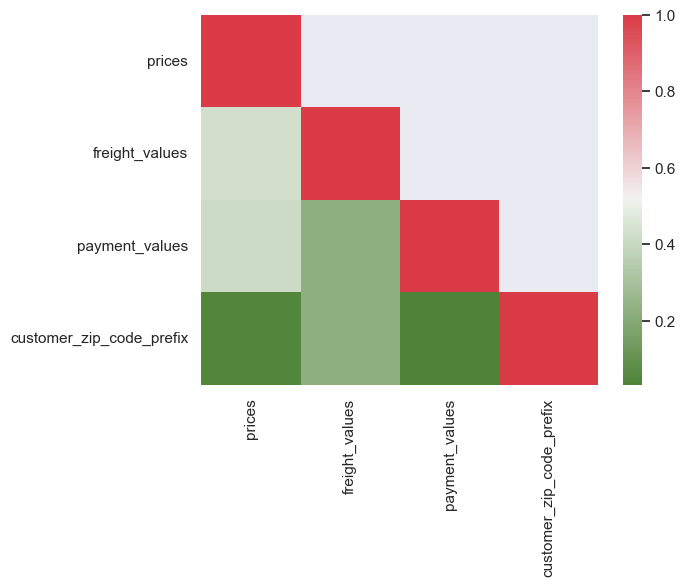

In [416]:
# Sacamos el id
dt = X_corr

corr = dt.corr() #returns a dataframe, so it can be reused

# Quitamos el triangulo superior para facilitar la lectura
bool_upper_matrix = np.tril(np.ones(corr.shape)).astype(np.bool)
corr = corr.where(bool_upper_matrix)

# Utilizamos el heatmap de seaborn para visualizar
sns.heatmap(corr, cmap=sns.diverging_palette(120, 10, as_cmap=True),
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [52]:
x = ventasz['customer_zip_code_prefix']
y = ventasz['prices']


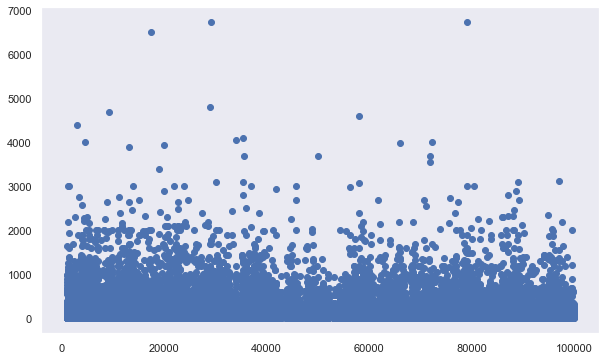

In [53]:
plt.scatter(x, y)
plt.grid()
plt.show()

In [54]:
x=y.to_numpy()
X=x[:,np.newaxis]
print(X.shape)

(93278, 1)


In [55]:
kmeans = KMeans(n_clusters=4, random_state=20) # K-Means con K=8
kmeans.fit(X)

KMeans(n_clusters=4, random_state=20)

In [56]:
etiquetas_1 = kmeans.labels_
print(etiquetas_1.shape)

(93278,)


In [57]:
centros_1 = kmeans.cluster_centers_
print(centros_1)

[[  69.92067421]
 [ 805.20507153]
 [2128.85483974]
 [ 255.45093754]]


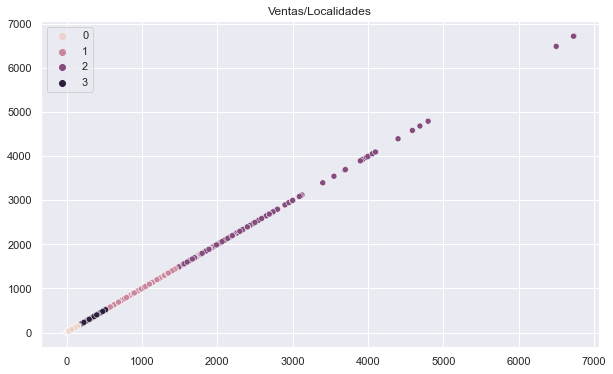

In [58]:
sns.scatterplot(X[:, 0], X[:, -1], hue = etiquetas_1)
#sns.scatterplot(centros_1[:, 0], centros_1[:, 1],color='black', marker="+")
plt.title('Ventas/Localidades')
plt.show()

Relacion Estado con Costo total de la compra

In [59]:
x = ventasz['customer_zip_code_prefix']
y = ventasz['payment_values']

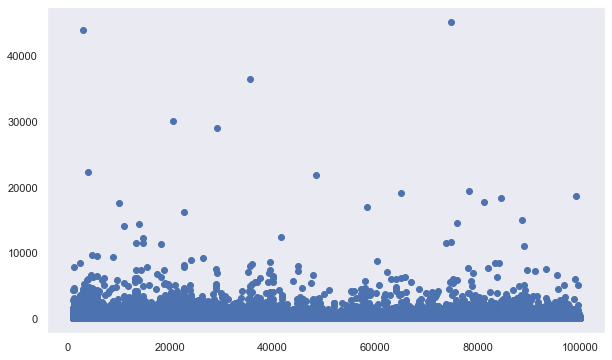

In [60]:
plt.scatter(x, y)
plt.grid()
plt.show()

In [61]:
y.shape

(93278,)

In [62]:
x=y.to_numpy()
X=x[:,np.newaxis]
print(X.shape)

(93278, 1)


In [63]:
kmeans = KMeans(n_clusters=4, random_state=20) # K-Means con K=4
kmeans.fit(X)

KMeans(n_clusters=4, random_state=20)

In [64]:
etiquetas_1 = kmeans.labels_
print(etiquetas_1.shape)

(93278,)


In [65]:
centros_1 = kmeans.cluster_centers_
print(centros_1)

[[ 1030.78527839]
 [ 4737.57644518]
 [22734.85842105]
 [  136.22104677]]


In [66]:
centros_1.shape

(4, 1)

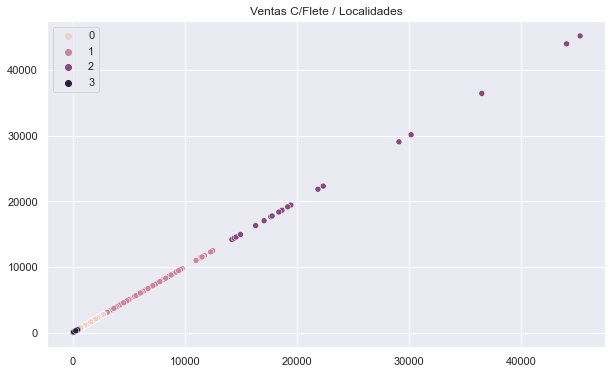

In [67]:
sns.scatterplot(X[:, 0], X[:, -1], hue = etiquetas_1)
#sns.scatterplot(centros_1[:, 0], centros_1[:, 1],color='black', marker="+", s=1000)
plt.title('Ventas C/Flete / Localidades')
plt.show()

In [438]:
x = ventasz['customer_zip_code_prefix']
y = ventasz['freight_values']

In [439]:
x=y.to_numpy()
X=x[:,np.newaxis]
print(X.shape)

(93278, 1)


In [440]:
kmeans = KMeans(n_clusters=4, random_state=20) # K-Means con K=8
kmeans.fit(X)

KMeans(n_clusters=4, random_state=20)

In [441]:
centros_1 = kmeans.cluster_centers_
print(centros_1)

[[ 30.4315631 ]
 [ 64.89482287]
 [153.94336336]
 [ 14.72924112]]


In [68]:
etiquetas_1 = kmeans.labels_
print(etiquetas_1.shape)

(93278,)


In [69]:
centros_1 = kmeans.cluster_centers_
print(centros_1)

[[ 1030.78527839]
 [ 4737.57644518]
 [22734.85842105]
 [  136.22104677]]


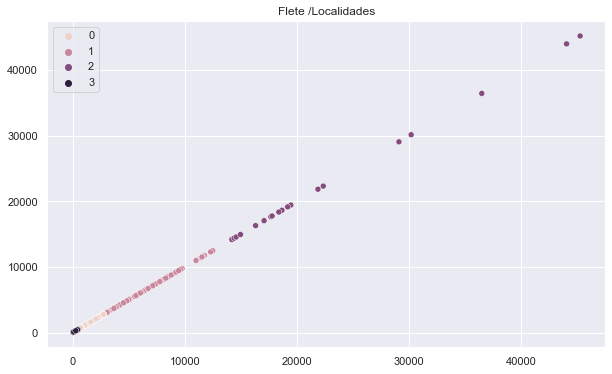

In [70]:
sns.scatterplot(X[:, 0], X[:, -1], hue = etiquetas_1)
#sns.scatterplot(centros_1[:, 0], centros_1[:, 1],color='black', marker="+", s=1000)
plt.title('Flete /Localidades')
plt.show()

In [71]:
ventasz.head()

,customer_id,prices,freight_values,payment_values,customer_zip_code_prefix,estado
0,3ce436f183e68e07877b285a838db11a,58.90,13.29,72.19,28013,RJ
1,ee55320c214a7ac7be7f488c6a63da0d,145.00,19.98,164.98,28013,RJ
2,7a9e4631c3fa2487b3a4d1a9becf3701,75.35,12.53,87.88,28013,RJ
3,c7858f425c53bf289b58bbca491fdfb6,19.90,16.79,36.69,28013,RJ
4,2622cbd2edf907bb373c679b09c01c01,129.50,16.67,146.17,28013,RJ


In [72]:
X=ventasz.drop("estado", axis=1)
X=X.drop( "customer_id", axis=1)
X=X.drop( "customer_zip_code_prefix", axis=1)
y=ventasz["estado"]
X

,prices,freight_values,payment_values
0,58.90,13.29,72.19
1,145.00,19.98,164.98
2,75.35,12.53,87.88
3,19.90,16.79,36.69
4,129.50,16.67,146.17
...,...,...,...
93274,109.90,27.24,137.14
93275,399.85,18.50,418.35
93276,32.99,15.10,48.09
93277,70.00,13.32,83.32


In [73]:
# estandarizar el conjunto de datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [74]:
# dividir en conjunto de entrenamiento (train) y 
#conjunto de prueba (test)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.10, random_state=42
)

In [75]:
# crear el clasificador
classifier = RandomForestClassifier(n_estimators=100)

# Entrenar el modelo usando el conjunto de entranamiento
classifier.fit(X_train, y_train)

RandomForestClassifier()

In [76]:
# predicción en el conjunto de prueba
y_pred = classifier.predict(X_test)

In [77]:
y_pred

array(['RS', 'SP', 'SP', ..., 'MG', 'SP', 'SP'], dtype=object)

In [78]:
# Calcular la precisión del modelo
print("Precisión:", accuracy_score(y_test, y_pred))

Precisión: 0.46880360205831906


In [79]:
# verificar características importantes
feature_importances_df = pd.DataFrame(
    {"feature": list(X.columns), "importance": classifier.feature_importances_}
).sort_values("importance", ascending=False)

# Mostrar
feature_importances_df

,feature,importance
1,freight_values,0.444427
2,payment_values,0.310583
0,prices,0.244990


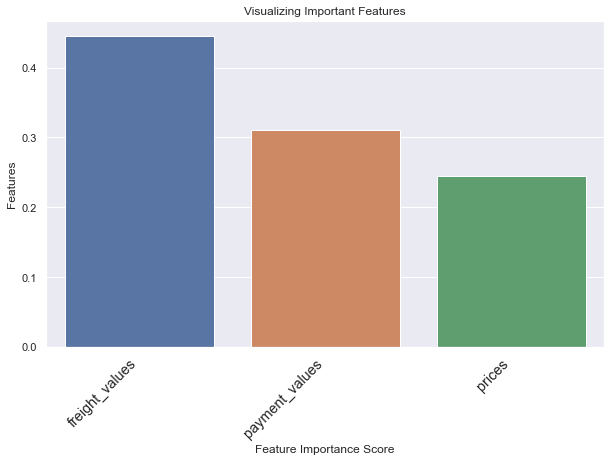

In [80]:
#visualizarcaracterísticas importantes para determinar si se puede mejorar la precisión del modelo

# Crear un diagrama de barras
sns.barplot(x=feature_importances_df.feature, y=feature_importances_df.importance)
# agregar estiquestas

plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Visualizing Important Features")
plt.xticks(
    rotation=45, horizontalalignment="right", fontweight="light", fontsize="x-large"
)
plt.show()

In [84]:
X=ventasz.drop("estado", axis=1)
X=X.drop( "customer_id", axis=1)
X=X.drop( "customer_zip_code_prefix", axis=1)
X=X.drop("prices", axis=1)
y=ventasz["estado"]
X

,freight_values,payment_values
0,13.29,72.19
1,19.98,164.98
2,12.53,87.88
3,16.79,36.69
4,16.67,146.17
...,...,...
93274,27.24,137.14
93275,18.50,418.35
93276,15.10,48.09
93277,13.32,83.32


In [85]:
# estandarizar el conjunto de datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# dividir en conjunto de entrenamiento y de prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.10, random_state=42
)

In [86]:
# crear clasificador
clf = RandomForestClassifier(n_estimators=100)

# Entrenar el modelo usando el conjunto de entrenamiento
clf.fit(X_train, y_train)

# predicción en el conjunto de prueba
y_pred = clf.predict(X_test)

# Calcular la precisión del modelo,
print("Precisión:", accuracy_score(y_test, y_pred))

Precisión: 0.4743782161234991


In [87]:
print("Prediccion y clasificación de compra periodicas por Estado", y_pred )

Prediccion de compra por Estado ['SP' 'SP' 'SP' ... 'MG' 'SP' 'SP']


In [8]:
venta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [10]:
ventasF= venta[["customer_id","order_status","order_purchase_timestamp","order_approved_at","order_delivered_carrier_date","order_delivered_customer_date","order_estimated_delivery_date"]]

In [11]:
ventasF.head()

,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [12]:
import datetime as dt
ventasF['diferencialenvios']= pd.to_datetime(ventasF['order_delivered_customer_date'], errors='coerce') - pd.to_datetime(ventasF['order_purchase_timestamp'], errors='coerce')
ventasF['diferencialenviosEstimados']= pd.to_datetime(ventasF['order_estimated_delivery_date'], errors='coerce') - pd.to_datetime(ventasF['order_delivered_customer_date'], errors='coerce')
ventasF['diferencialcarried']= pd.to_datetime(ventasF['order_delivered_customer_date'], errors='coerce') - pd.to_datetime(ventasF['order_delivered_carrier_date'], errors='coerce')

In [13]:
ventasF1= ventasF[["customer_id","order_status", "diferencialenvios","diferencialenviosEstimados","diferencialcarried"]]
ventasF1

,customer_id,order_status,diferencialenvios,diferencialenviosEstimados,diferencialcarried
0,9ef432eb6251297304e76186b10a928d,delivered,8 days 10:28:40,7 days 02:34:47,6 days 01:30:13
1,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,13 days 18:46:08,5 days 08:32:15,12 days 00:56:45
2,41ce2a54c0b03bf3443c3d931a367089,delivered,9 days 09:27:40,17 days 05:53:31,9 days 04:16:29
3,f88197465ea7920adcdbec7375364d82,delivered,13 days 05:00:36,12 days 23:31:18,9 days 10:48:43
4,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2 days 20:58:23,9 days 05:42:58,1 days 22:30:28
...,...,...,...,...,...
99436,39bd1228ee8140590ac3aca26f2dfe00,delivered,8 days 05:13:56,10 days 08:51:59,7 days 03:49:58
99437,1fca14ff2861355f6e5f14306ff977a7,delivered,22 days 04:38:58,1 days 06:22:04,20 days 18:15:14
99438,1aa71eb042121263aafbe80c1b562c9c,delivered,24 days 20:37:34,5 days 12:35:43,23 days 14:31:51
99439,b331b74b18dc79bcdf6532d51e1637c1,delivered,17 days 02:04:27,20 days 00:27:06,13 days 07:57:51


In [14]:
X=ventasF1.drop("customer_id", axis=1)
X=X.drop("order_status", axis=1)
y=ventasF1["order_status"]

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.10, random_state=42
)

In [17]:
# crear clasificador
clf = RandomForestClassifier(n_estimators=100)

# Entrenar el modelo usando el conjunto de entrenamiento
clf.fit(X_train, y_train)

# predicción en el conjunto de prueba
y_pred = clf.predict(X_test)

# Calcular la precisión del modelo,
print("Precisión:", accuracy_score(y_test, y_pred))

Precisión: 0.9813976872800402


In [18]:
print("Prediccion y clasificación de estatus de la orden", y_pred )

Prediccion y clasificación de compra periodicas por Estado ['delivered' 'delivered' 'delivered' ... 'delivered' 'delivered'
 'delivered']
